Playground
---

List of regressors and their hyperparameters

## Linear Regressors
in `sklearn.linear_model`

#### `LinearRegression`
 * Force positive coefficients (e.g. Ordinary least squares vs. Non-Negative least squares): `positive=True`

#### `Ridge`
 * Complexity parameter $\alpha$: `alpha=.5` (defaults to 1.0)
 * Force positive coefficients: `positive=True`
 * Solver method: `solver =` ` 'auto'`, `'svd'`, `'cholesky'`, `'lsqr'`, `'sparse_cg'`, `'sag'`, `'saga'` or `'lbfgs'`

#### `RidgeCV`
 * Same as above with built-in cross validation: defaults to "leave-one-out", `cv=10` triggers 10-fold `GridSearchCV` 
 
#### `Lasso`
 * Sparsity parameter $\alpha$: `alpha=.1` (defaults to 1.0)
 * Force positive coefficients: `positive=True`


#### `LassoCV`
 * Same as above with built-in cross validation: default 5-fold cross-validation, `cv=10` triggers 10-fold `GridSearchCV` 
 
#### `LassoLars`
 * Lasso with Least Angle Regression 

#### `LassoLarsCV`
 * Same as above with built-in cross validation: default 5-fold cross-validation, `cv=10` triggers 10-fold `GridSearchCV` 
 
#### `LassoLarsIC`
* `Lasso` with information-criteria based model selection

#### `MultiTaskLasso`
* `Lasso` with y being a 2D array, of shape (n_samples, n_tasks)

#### `ElasticNet` & `ElasticNetCV`
* ...

#### `MultiTaskElasticNet` & `MultiTaskElasticNetCV`
* ...
* `ElasticNet` with y being a 2D array, of shape (n_samples, n_tasks)

#### `OrthogonalMatchingPursuit`
* ...

#### `BayesianRidge`
* ...

#### `ARDRegression` (Automatic Relevance Determination)
* ...

#### `TweedieRegressor` (GenLins)
* `power`, `alpha`, `link=` z.B. `'log'`
* `power = 1` equivalent to `PoissonRegressor`
* `power = 2` equivalent to `GammaRegressor`
* `power = 3` Inverse Gaussian distribution.

#### `SGDRegressor`
* ...

#### `Perceptron`
* ...

#### `PassiveAggressiveRegressor`
* ...

#### `HuberRegressor` & `TheilSenRegressor` & `RANSACRegressor`
* ...

#### `QuantileRegressor`
* ...

#### `PolynomialFeatures`
* ...

**Implement XGBRegressor?**

```python
from xgboost import XGBRegressor
```

In [4]:
y

,audit
1,8.0
2,10.0
3,4.0
4,18.0
5,4.0
...,...
904,2.0
905,2.0
906,12.0
907,7.0


In [16]:
%%time

from sklearn.model_selection import GroupShuffleSplit
from skopt import BayesSearchCV 
from get_data import get_mindfulness as get_data
from regressors import get_regressor
from utils import split_train_test
from skopt.plots import plot_objective, plot_evaluations, plot_convergence
import matplotlib.pyplot as plt
import numpy as np
import time


X, y = get_data()


for reg_type in ["elasticnet", "rf", "extratrees", "gradientboost"]:

    reg,hyperparams_dist = get_regressor(reg_type) # "elasticnet", "rf", "extratrees", "gradientboost"


    outer_cv = GroupShuffleSplit(n_splits=5,
                                 test_size=0.2,
                                 random_state=0
                                )

    # iterate over outer CV splitter
    for i_cv, (i_train, i_test) in enumerate(outer_cv.split(X, y, groups=X.index), start=1):

        y_train, y_test = split_train_test(y, i_train, i_test)
        X_train, X_test = split_train_test(X, i_train, i_test)

        # nested CV with parameter optimization
        search_reg = BayesSearchCV(
            estimator=reg,
            search_spaces=hyperparams_dist,
            n_iter=200, # set to higher value 100,200,...
            cv=5,
            n_jobs=8,
            random_state=0
        )

        result = search_reg.fit(X_train, y_train.values.ravel())

        print(f"Split {i_cv}:", result.best_estimator_)
        print("train score:", round(result.score(X_train, y_train), 5))
        print("test  score:", round(result.score(X_test, y_test), 5))
        print("\n")

    plot_convergence(search_reg.optimizer_results_)
    plt.show()
    plot_evaluations(search_reg.optimizer_results_[0])
    plt.show()
    plot_objective(search_reg.optimizer_results_[0])
    plt.show()

Split 1: ElasticNet(alpha=0.18730797656592243, l1_ratio=1.0)
train score: 0.4055
test  score: 0.36027


Split 2: ElasticNet(alpha=0.46191843924044185, l1_ratio=0.44139348917609544)
train score: 0.35555
test  score: 0.33279




KeyboardInterrupt: 

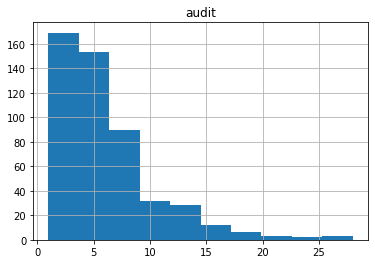

In [17]:
y.hist();

In [18]:
# features with highest correlations (abs. correlations!)
np.abs(X.join(y).corr()[y.columns[0]]).sort_values(ascending=False)[1:]

dmq_cope_4             0.450675
dmq_cope_2             0.435024
dmq_cope_1             0.405141
dmq_cope_5             0.392597
dmq_cope_3             0.392297
upps_ur_2              0.283843
upps_ur_5              0.259460
upps_ss_2              0.236721
upps_ss_4              0.227254
upps_ur_3              0.224429
upps_pe_5              0.223714
geschlecht_kod_male    0.217500
ffmq_nj3               0.203715
ffmq_aa2               0.189522
ffmq_nj1               0.187822
ffmq_aa3               0.179862
upps_ss_3              0.178833
ffmq_ob3               0.171105
upps_pe_3              0.168995
upps_ss_5              0.164438
upps_pe_4              0.156496
ffmq_aa1               0.155062
upps_pm_2              0.148586
ffmq_ob4               0.144535
ffmq_nr3               0.135451
ffmq_aa4               0.131091
upps_pm_5              0.127894
upps_ur_1              0.126837
ffmq_ob1               0.121670
ffmq_ds1               0.121373
ffmq_ds4               0.113810
ffmq_ob2

**Plot LinearRegression**

In [26]:
cv_results = search_reg.cv_results_

TypeError: Cannot convert fill_value ? to dtype float64

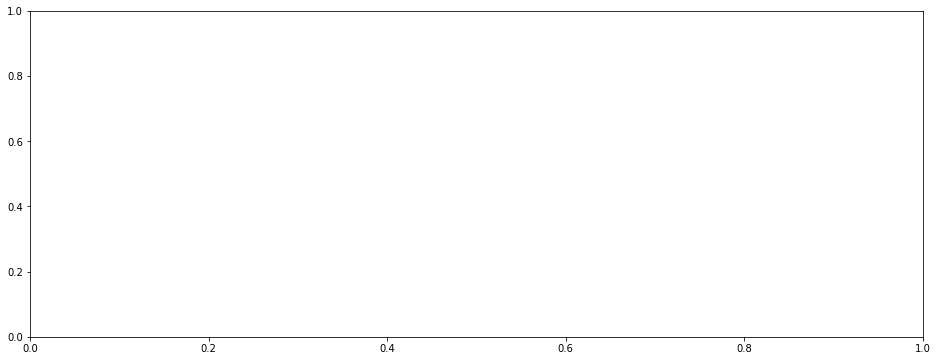

In [27]:
hp_to_plot="alpha"

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_" + hp_to_plot], cv_results["mean_test_score"])
plt.plot(cv_results["param_" + hp_to_plot], cv_results["mean_train_score"])
plt.xlabel(hp_to_plot)
plt.ylabel('r-squared')
plt.title("Optimal " + hp_to_plot)
plt.legend(['test score', 'train score'], loc='upper left')

In [157]:
# final model
alpha = 0.6
l1_ratio = 1

lin_reg = ElasticNet(alpha=alpha,l1_ratio=l1_ratio)
lin_reg.fit(X_train, y_train)


# predict X_test
y_pred = lin_reg.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.6637183423818207


**RandomForest**

In [170]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 0)

# step-2: specify range of hyperparameters to tune
hyper_params = {"criterion": ["squared_error", "absolute_error", "poisson"],"n_estimators":[10,20,50,100,200,500]}


# step-3: perform grid search
# 3.1 specify model
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

print("Score train: ",rf_reg.score(X_train,y_train))
print("Score test:  ",rf_reg.score(X_test,y_test))

Score train:  0.9511111762499406
Score test:   0.5901294979252275


In [171]:
# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rf_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [172]:
print(model_cv.best_estimator_,"=>",model_cv.best_score_)

RandomForestRegressor(criterion='absolute_error', n_estimators=20) => 0.6225883745313235


In [176]:
# final model
criterion = "absolute_error"
n_estimators = 20

rf_reg = RandomForestRegressor(n_estimators=n_estimators,criterion=criterion)
rf_reg.fit(X_train, y_train)


# predict X_test
y_pred = rf_reg.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.6108154779093546
